In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('transactions_month_9.csv')

In [3]:
df.head()

,Date/Time,From_Account_id,To_Account_id,amount,Year,Month,Day,Hour,Minute,Transaction_Count,Average_Transaction_Amount
0,2024-09-01 00:00:00,2533596,2166482,850.0,2024.0,9.0,1.0,0.0,0.0,129.0,828.02
1,2024-09-01 00:00:04,6573727,6881602,50.0,2024.0,9.0,1.0,0.0,0.0,74.0,522.49
2,2024-09-01 00:00:04,736527,106843,1300.0,2024.0,9.0,1.0,0.0,0.0,20.0,805.50
3,2024-09-01 00:00:05,2968740,517927,631.0,2024.0,9.0,1.0,0.0,0.0,44.0,1064.48
4,2024-09-01 00:00:05,799825,7037682,25000.0,2024.0,9.0,1.0,0.0,0.0,136.0,4469.96


In [4]:
df['amount'].min()

1.0

In [5]:
df.isna().sum()

,0
Date/Time,0
From_Account_id,0
To_Account_id,0
amount,1
Year,1
Month,1
Day,1
Hour,1
Minute,1
Transaction_Count,1


In [6]:
df.duplicated().sum()

0

In [7]:
df = df.drop_duplicates()
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31605 entries, 0 to 31604
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date/Time                   31605 non-null  object 
 1   From_Account_id             31605 non-null  int64  
 2   To_Account_id               31605 non-null  int64  
 3   amount                      31605 non-null  float64
 4   Year                        31605 non-null  float64
 5   Month                       31605 non-null  float64
 6   Day                         31605 non-null  float64
 7   Hour                        31605 non-null  float64
 8   Minute                      31605 non-null  float64
 9   Transaction_Count           31605 non-null  float64
 10  Average_Transaction_Amount  31605 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 2.9+ MB


In [9]:
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.head()

,Date/Time,From_Account_id,To_Account_id,amount,Year,Month,Day,Hour,Minute,Transaction_Count,Average_Transaction_Amount
0,2024-09-01 00:00:00,2533596,2166482,850.0,2024.0,9.0,1.0,0.0,0.0,129.0,828.02
1,2024-09-01 00:00:04,6573727,6881602,50.0,2024.0,9.0,1.0,0.0,0.0,74.0,522.49
2,2024-09-01 00:00:04,736527,106843,1300.0,2024.0,9.0,1.0,0.0,0.0,20.0,805.50
3,2024-09-01 00:00:05,2968740,517927,631.0,2024.0,9.0,1.0,0.0,0.0,44.0,1064.48
4,2024-09-01 00:00:05,799825,7037682,25000.0,2024.0,9.0,1.0,0.0,0.0,136.0,4469.96


In [11]:
!pip install pyspark

In [12]:
!pyspark --packages graphframes:graphframes:0.8.2-spark3.0-s_2.12

Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9110c185-f11b-4620-bcb2-89854698d025;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.0-s_2.12!graphframes.jar (91ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ]

In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AML Detection") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12") \
    .getOrCreate()

spark_df = spark.createDataFrame(df)

# spark.stop()

In [14]:
# spark_df.filter(F.col("amount") > 10)
# spark_df.groupBy("From_Account_id", "To_Account_id").count().filter(F.col("count") >= 3)


In [15]:
from pyspark.sql import functions as F
data = spark_df.dropDuplicates(["Date/Time", "From_Account_id", "To_Account_id", "amount"])

aggregated = data.groupBy("From_Account_id", "To_Account_id").agg(
    F.count("*").alias("Total_Transaction_Count"),
    F.avg("amount").alias("Average_Transaction_Amount"),
    F.min("Date/Time").alias("First_Transaction"),
    F.max("Date/Time").alias("Last_Transaction")
)
aggregated = aggregated.withColumn(
    "Temporal_Span", F.datediff("Last_Transaction", "First_Transaction")
)
filtered = aggregated.filter(
    (F.col("Average_Transaction_Amount") > 100)&
     (F.col("Total_Transaction_Count") >= 3))

filtered = filtered.filter(F.col("From_Account_id") != F.col("To_Account_id"))
filtered.show()

+---------------+-------------+-----------------------+--------------------------+-------------------+-------------------+-------------+
|From_Account_id|To_Account_id|Total_Transaction_Count|Average_Transaction_Amount|  First_Transaction|   Last_Transaction|Temporal_Span|
+---------------+-------------+-----------------------+--------------------------+-------------------+-------------------+-------------+
|          73042|      9262082|                      3|                    2200.0|2024-09-01 07:41:31|2024-09-01 09:08:45|            0|
|         129993|       372368|                      4|                    7500.0|2024-09-01 01:36:15|2024-09-01 05:11:36|            0|
|         420765|      4171581|                      3|         266.6666666666667|2024-09-01 08:28:43|2024-09-01 08:35:58|            0|
|         476439|      2313938|                      3|                   16750.0|2024-09-01 08:46:17|2024-09-01 08:48:32|            0|
|         496152|      5564791|          

In [16]:
from graphframes import GraphFrame

In [17]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

vertices = data.select(F.col("From_Account_id").alias("id")).union(
    data.select(F.col("To_Account_id").alias("id"))
).distinct()

edges = data.select(
    F.col("From_Account_id").alias("src"),
    F.col("To_Account_id").alias("dst"),
    F.col("amount"),
    F.col("Date/Time")
)
graph = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# Circular Transactions: Strongly Connected Components (SCC)

In [18]:
# SCC algorithm
scc = graph.stronglyConnectedComponents(maxIter=10)
circular_clusters = scc.groupBy("component").count().filter(F.col("count") > 1)
circular_clusters.show()

import networkx as nx
import matplotlib.pyplot as plt

edges_pd = edges.toPandas()
G = nx.from_pandas_edgelist(edges_pd, source="src", target="dst", create_using=nx.DiGraph())

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---------+-----+
|component|count|
+---------+-----+
|  1535457|    2|
|  7706733|    2|
|   440481|    2|
|  3843972|    2|
|   313491|    2|
|  7986029|    2|
|  6329357|    2|
|  6441786|    2|
|  1843409|    2|
|  8132398|    2|
|  7538946|    2|
|  8171664|    2|
|  3608552|    2|
|  3627451|    2|
|  5914883|    2|
|  2094994|    2|
|  2452690|    2|
|   460991|    2|
|  5114583|    3|
|   496152|    3|
+---------+-----+
only showing top 20 rows



In [19]:
# Sort clusters by count in descending order and select the top 10
flagged_clusters = circular_clusters.orderBy(F.col("count").desc()).limit(10)
flagged_clusters.show()
flagged_clusters_pd = flagged_clusters.toPandas()
print("Flagged Circular Clusters:")
print(flagged_clusters_pd)

+---------+-----+
|component|count|
+---------+-----+
|   282286|   36|
|   668287|   13|
|   864714|    4|
|  6782223|    4|
|   597837|    4|
|  5486802|    4|
|   496152|    3|
|  3293927|    3|
|  5114583|    3|
|  5583442|    3|
+---------+-----+

Flagged Circular Clusters:
   component  count
0     282286     36
1     668287     13
2     864714      4
3    6782223      4
4     597837      4
5    5486802      4
6     496152      3
7    3293927      3
8    5114583      3
9    5583442      3


In [20]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_circular_transactions(account_id, scc_pd, edges_pd):
    component = scc_pd[scc_pd["id"] == int(account_id)]["component"].values
    if len(component) == 0:
        print(f"No component found for account ID {account_id}.")
        return

    component = component[0]
    component_nodes = scc_pd[scc_pd["component"] == component]["id"].values
    component_edges = edges_pd[
        (edges_pd["src"].isin(component_nodes)) & (edges_pd["dst"].isin(component_nodes))
    ]

    if component_edges.empty:
        print(f"No circular transactions found for account ID {account_id}.")
    else:
        G = nx.from_pandas_edgelist(
            component_edges, source="src", target="dst", create_using=nx.DiGraph()
        )
        plt.figure(figsize=(12, 8))
        nx.draw_networkx(
            G,
            with_labels=True,
            node_size=500,
            node_color="lightblue",
            font_size=10,
            arrowsize=15,
        )
        plt.title(f"Circular Transactions for Component {component} (Account: {account_id})")
        plt.show()
scc_pd = scc.toPandas()
edges_pd = edges.toPandas()

Enter the account ID to visualize circular transactions (or type 'n' to stop): 282286


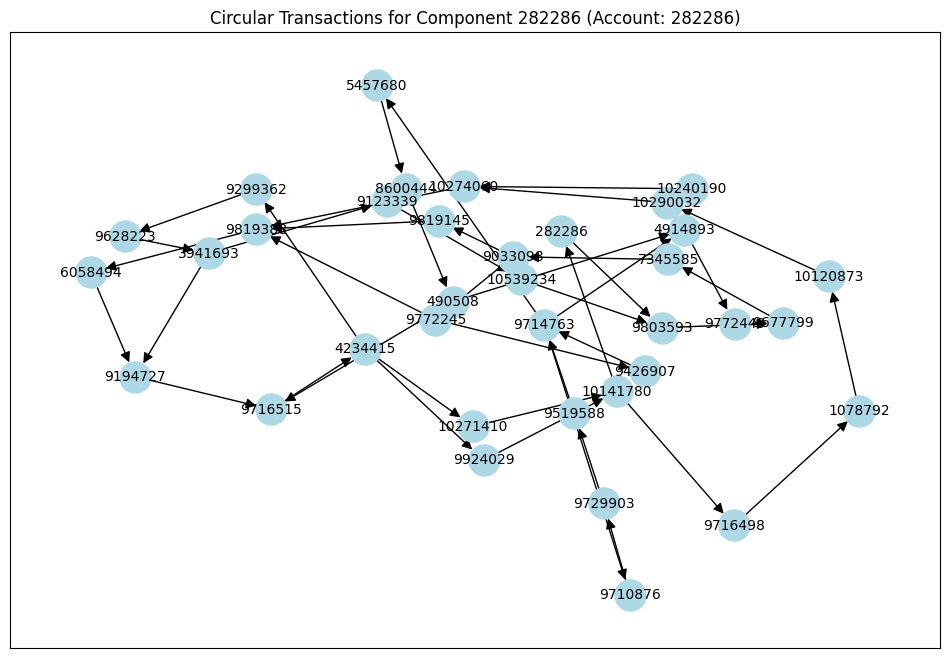

In [21]:
account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
if account_id.lower() in ['n', 'stop']:
    print("Exiting visualization.")
if not account_id.isdigit():
    print("Invalid input. Please enter a valid numeric account ID.")
visualize_circular_transactions(account_id, scc_pd, edges_pd)

Enter the account ID to visualize circular transactions (or type 'n' to stop): 668287


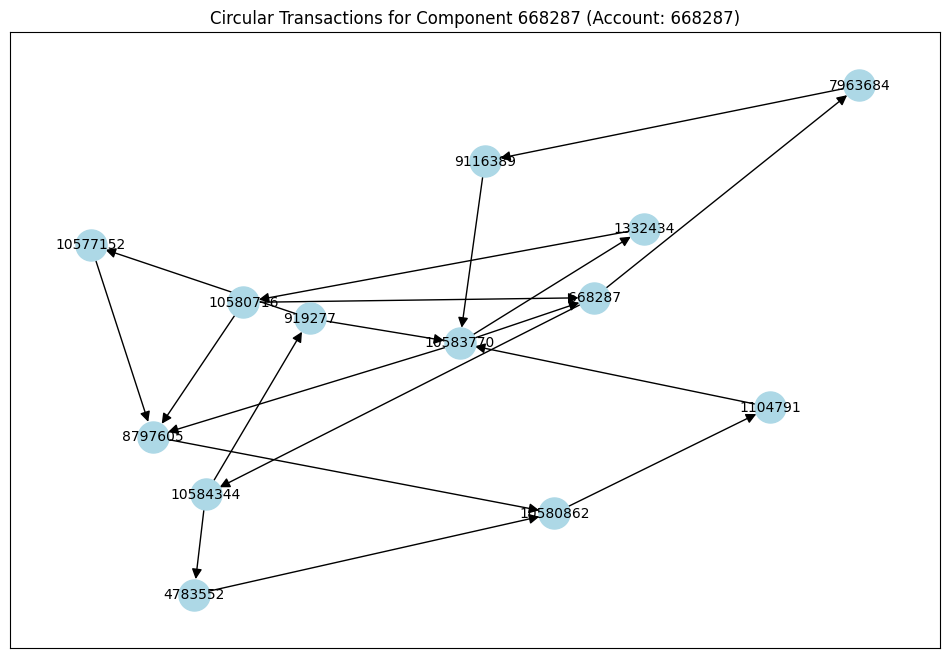

In [22]:
account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
if account_id.lower() in ['n', 'stop']:
    print("Exiting visualization.")
if not account_id.isdigit():
    print("Invalid input. Please enter a valid numeric account ID.")
visualize_circular_transactions(account_id, scc_pd, edges_pd)

Enter the account ID to visualize circular transactions (or type 'n' to stop): 864714


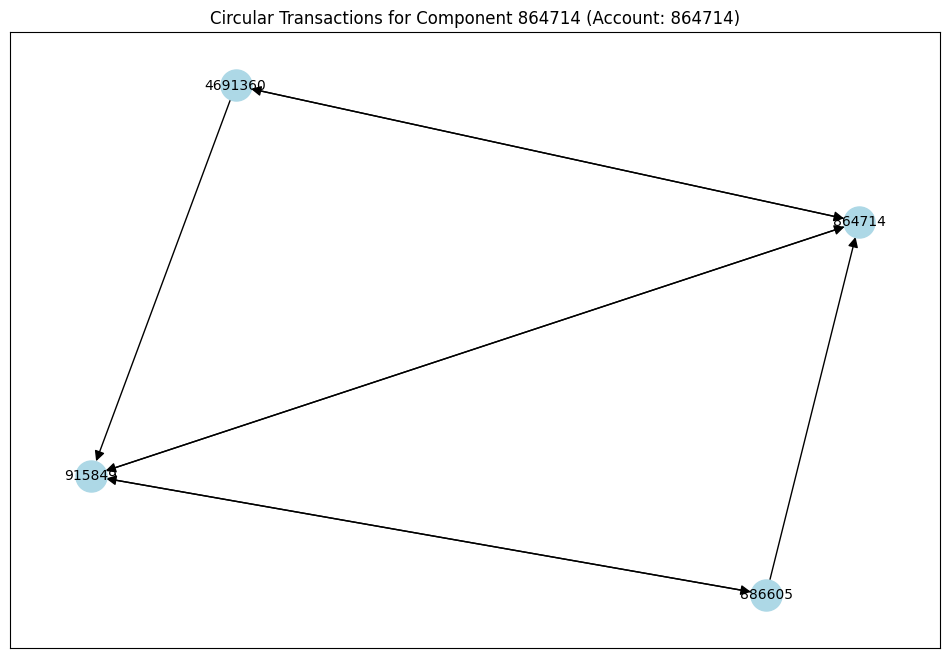

In [23]:
account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
if account_id.lower() in ['n', 'stop']:
    print("Exiting visualization.")
if not account_id.isdigit():
    print("Invalid input. Please enter a valid numeric account ID.")
visualize_circular_transactions(account_id, scc_pd, edges_pd)

Enter the account ID to visualize circular transactions (or type 'n' to stop):  6782223 
Invalid input. Please enter a valid numeric account ID.


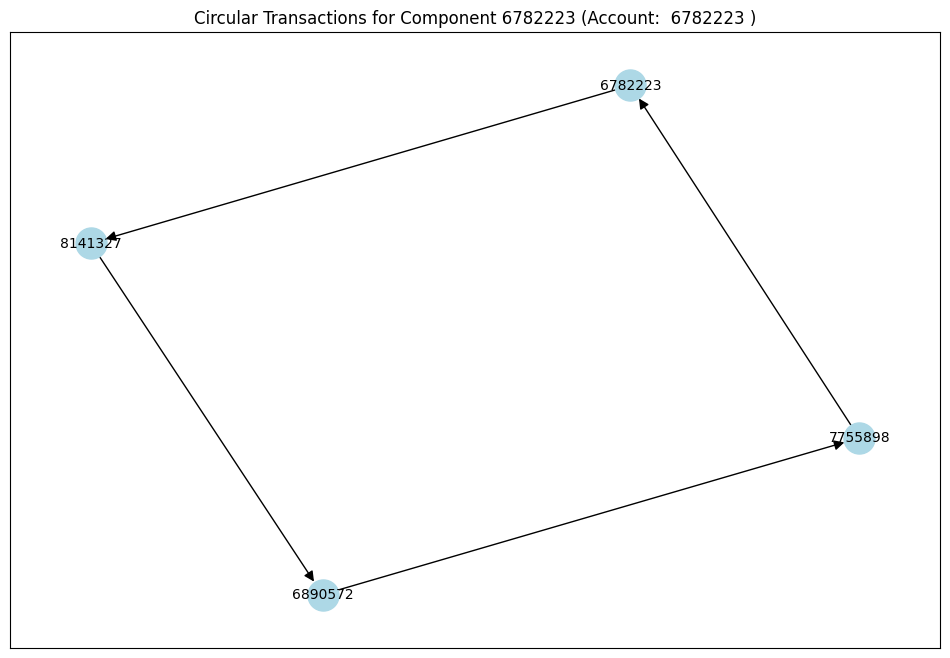

In [24]:
account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
if account_id.lower() in ['n', 'stop']:
    print("Exiting visualization.")
if not account_id.isdigit():
    print("Invalid input. Please enter a valid numeric account ID.")
visualize_circular_transactions(account_id, scc_pd, edges_pd)

Enter the account ID to visualize circular transactions (or type 'n' to stop): 597837 
Invalid input. Please enter a valid numeric account ID.


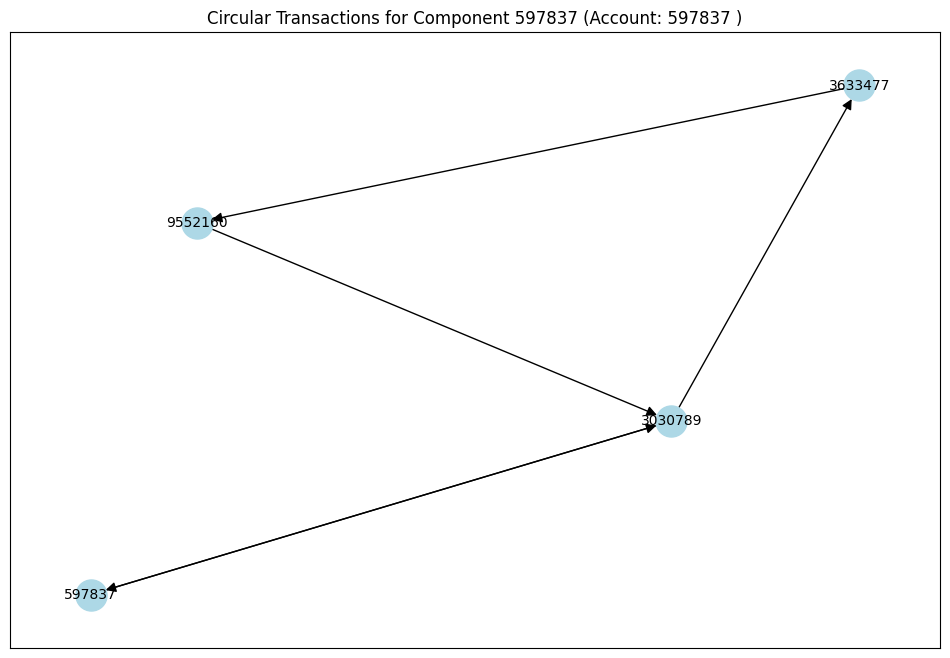

In [25]:
account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
if account_id.lower() in ['n', 'stop']:
    print("Exiting visualization.")
if not account_id.isdigit():
    print("Invalid input. Please enter a valid numeric account ID.")
visualize_circular_transactions(account_id, scc_pd, edges_pd)

In [ ]:
# account_id = input("Enter the account ID to visualize circular transactions (or type 'n' to stop): ")
# if account_id.lower() in ['n', 'stop']:
#     print("Exiting visualization.")
# if not account_id.isdigit():
#     print("Invalid input. Please enter a valid numeric account ID.")
# visualize_circular_transactions(account_id, scc_pd, edges_pd)

In [ ]:
# # Plot the graph
# plt.figure(figsize=(12, 8))
# nx.draw_networkx(G, with_labels=False, node_size=10, arrows=True)
# plt.title("Circular Transactions")
# plt.show()

# BFS backtracking


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


root
 |-- from: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |-- e0: struct (nullable = false)
 |    |-- src: long (nullable = true)
 |    |-- dst: long (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- Date/Time: string (nullable = true)
 |-- v1: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |-- e1: struct (nullable = false)
 |    |-- src: long (nullable = true)
 |    |-- dst: long (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- Date/Time: string (nullable = true)
 |-- v2: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |-- e2: struct (nullable = false)
 |    |-- src: long (nullable = true)
 |    |-- dst: long (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- Date/Time: string (nullable = true)
 |-- v3: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |-- e3: struct (nullable = false)
 |    |-- src: long (nullable = true)
 |    |-- dst: long (nullable = 

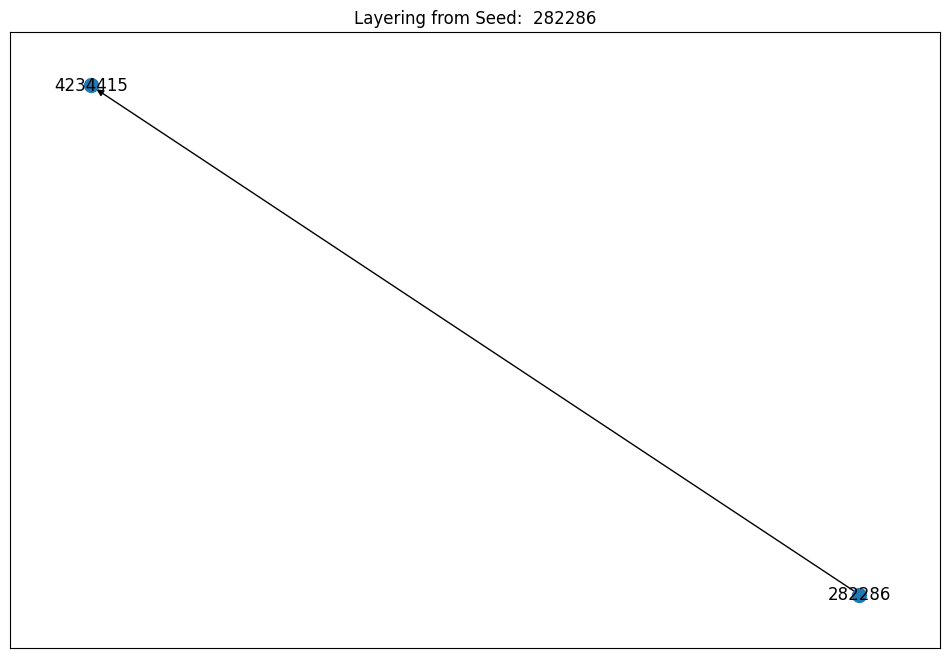

In [29]:
seed_account = " 282286"
to_account = "4234415"
# 9819145
bfs = graph.bfs(
    fromExpr=f"id = '{seed_account}'",
    toExpr=f"id ='{to_account}'",
    maxPathLength=10
)

bfs.printSchema()
bfs.show(truncate=False)

if bfs.count() > 0:
    layer_edges = bfs.select(F.col("from.id").alias("src"), F.col("to.id").alias("dst"))
    layer_edges_pd = layer_edges.toPandas()
    G = nx.from_pandas_edgelist(layer_edges_pd, source="src", target="dst", create_using=nx.DiGraph())
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, with_labels=True, node_size=100, arrows=True)
    plt.title(f"Layering from Seed: {seed_account}")
    plt.show()
else:
    print("No paths found from the seed account.")

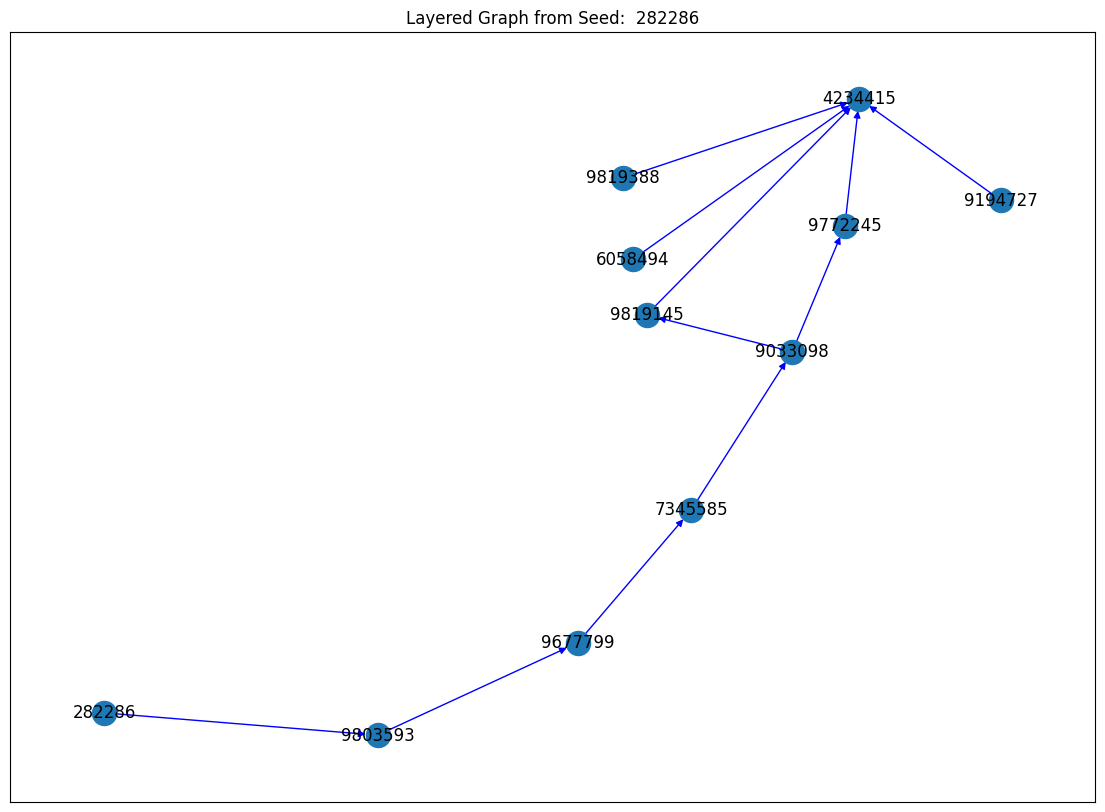

In [30]:
layer_edges = []
for i in range(9):
    from_col = f"from.id" if i == 0 else f"v{i}.id"
    to_col = f"v{i+1}.id" if i < 5 else "to.id"
    edge_col = f"e{i}"
    if edge_col in bfs.columns:
        edges = bfs.select(F.col(from_col).alias("src"),
                           F.col(to_col).alias("dst"),
                           F.col(f"{edge_col}.amount").alias("amount"),
                           F.col(f"{edge_col}.Date/Time").alias("datetime"))
        layer_edges.append(edges)

# Combine all edges
if layer_edges:
    all_edges = layer_edges[0]
    for edge_df in layer_edges[1:]:
        all_edges = all_edges.union(edge_df)
    layer_edges_pd = all_edges.toPandas()
    G = nx.from_pandas_edgelist(layer_edges_pd, source="src", target="dst", create_using=nx.DiGraph())
    plt.figure(figsize=(14, 10))
    nx.draw_networkx(G, with_labels=True, node_size=300, arrows=True, edge_color="blue")
    plt.title(f"Layered Graph from Seed: {seed_account}")
    plt.show()
else:
    print("No valid edges found in BFS result.")

# Smurfing Detection

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------+------+---------+----------+
|account|degree|in_degree|out_degree|
+-------+------+---------+----------+
|7949952|    22|       11|        11|
+-------+------+---------+----------+

+--------+------+---------+----------+
| account|degree|in_degree|out_degree|
+--------+------+---------+----------+
| 9818886|    18|       11|         7|
| 8027613|    13|       11|         2|
| 9973376|    16|       12|         4|
| 8616165|    19|       13|         6|
|  590169|    14|       12|         2|
| 9924029|    26|       17|         9|
| 9272138|    17|       11|         6|
|10072584|    14|       11|         3|
| 9196215|    22|       12|        10|
| 7949952|    22|       11|        11|
|10141780|    19|       15|         4|
| 7937437|    16|       11|         5|
| 8726347|    18|       11|         7|
| 9705009|    15|       15|         0|
| 9710866|    18|       13|         5|
|10010824|    17|       11|         6|
| 9772449|    21|       13|         8|
+--------+------+---------+--

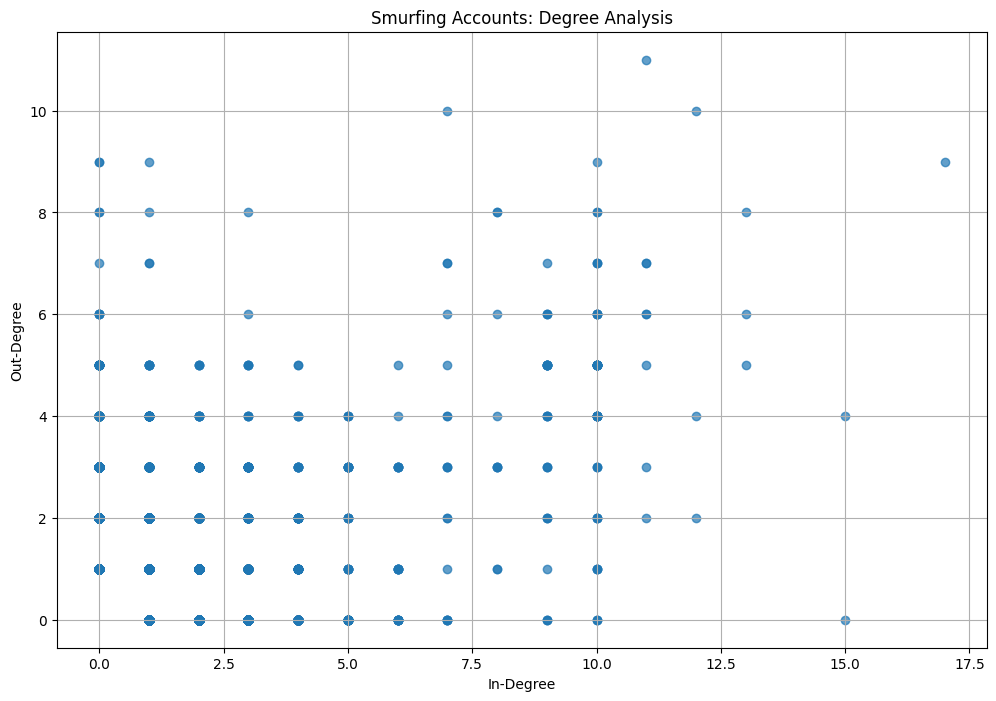

In [31]:
# Calculate in-degree and out-degree
degrees = graph.degrees.withColumnRenamed("id", "account")
in_degrees = graph.inDegrees.withColumnRenamed("id", "account").withColumnRenamed("inDegree", "in_degree")  # Rename 'id' to 'account'
out_degrees = graph.outDegrees.withColumnRenamed("id", "account").withColumnRenamed("outDegree", "out_degree") # Rename 'id' to 'account'

# Merge degrees
degree_analysis = degrees.join(in_degrees, "account", "outer").join(out_degrees, "account", "outer")
degree_analysis = degree_analysis.fillna(0)
smurfing_origins = degree_analysis.filter(F.col("out_degree") > 10)
smurfing_endpoints = degree_analysis.filter(F.col("in_degree") > 10)

smurfing_origins.show()
smurfing_endpoints.show()
degree_pd = degree_analysis.toPandas()
plt.figure(figsize=(12, 8))
plt.scatter(degree_pd["in_degree"], degree_pd["out_degree"], alpha=0.7)
plt.xlabel("In-Degree")
plt.ylabel("Out-Degree")
plt.title("Smurfing Accounts: Degree Analysis")
plt.grid()
plt.show()


In [32]:
# Sort and display top 10 accounts by in-degree and  out-degree
top_in_degree = degree_analysis.orderBy(F.col("in_degree").desc()).limit(10)
top_out_degree = degree_analysis.orderBy(F.col("out_degree").desc()).limit(10)
print("Top 10 High Total Degree Accounts")

degree_analysis = degree_analysis.withColumn("total_degree", F.col("in_degree") + F.col("out_degree"))
top_total_degree = degree_analysis.orderBy(F.col("total_degree").desc()).limit(10)
top_total_degree.show(truncate=False)

smurfing_origins = degree_analysis.orderBy(F.col("out_degree").desc()).limit(10)
print("Top 10 Smurfing Origins:(High Out-Degree Accounts)")
smurfing_origins.show(truncate=False)

smurfing_endpoints = degree_analysis.orderBy(F.col("in_degree").desc()).limit(10)
print("Top 10 Smurfing Endpoints: (High In-degree Accounts)")
smurfing_endpoints.show(truncate=False)

Top 10 High Total Degree Accounts
+--------+------+---------+----------+------------+
|account |degree|in_degree|out_degree|total_degree|
+--------+------+---------+----------+------------+
|9924029 |26    |17       |9         |26          |
|7949952 |22    |11       |11        |22          |
|9196215 |22    |12       |10        |22          |
|9772449 |21    |13       |8         |21          |
|8616165 |19    |13       |6         |19          |
|10141780|19    |15       |4         |19          |
|10584344|19    |10       |9         |19          |
|8726347 |18    |11       |7         |18          |
|8141327 |18    |10       |8         |18          |
|9710866 |18    |13       |5         |18          |
+--------+------+---------+----------+------------+

Top 10 Smurfing Origins:(High Out-Degree Accounts)
+--------+------+---------+----------+------------+
|account |degree|in_degree|out_degree|total_degree|
+--------+------+---------+----------+------------+
|7949952 |22    |11       |11 

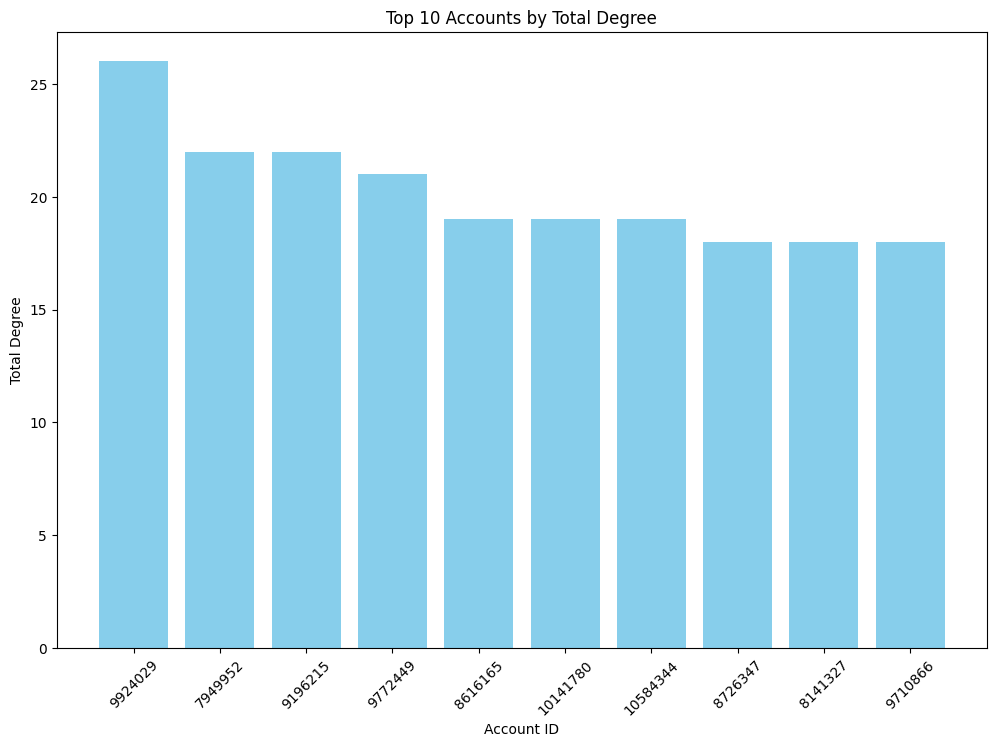

In [33]:
# Convert top accounts to Pandas for visualization
top_degree_pd = degree_analysis.orderBy(F.col("total_degree").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 8))
plt.bar(top_degree_pd["account"].astype(str), top_degree_pd["total_degree"], color="skyblue")
plt.xlabel("Account ID")
plt.ylabel("Total Degree")
plt.title("Top 10 Accounts by Total Degree")
plt.xticks(rotation=45)
plt.show()

## PageRank

In [34]:
# Run PageRank
pagerank = graph.pageRank(resetProbability=0.15, maxIter=15)
pagerank.vertices.orderBy(F.desc("pagerank")).show(10)
pagerank_pd = pagerank.vertices.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+--------+------------------+
|      id|          pagerank|
+--------+------------------+
| 8027613|19.398780543457406|
|10280883|18.825868998701196|
|10141780|15.595908378123951|
| 2035891|15.224668126102925|
| 9819145|  13.7231077763529|
| 9714763| 13.05648408954029|
|10290032|12.841045428553914|
| 9885265|12.097969190681987|
| 9818538| 12.06536311853494|
| 9729903|11.436939631683671|
+--------+------------------+
only showing top 10 rows



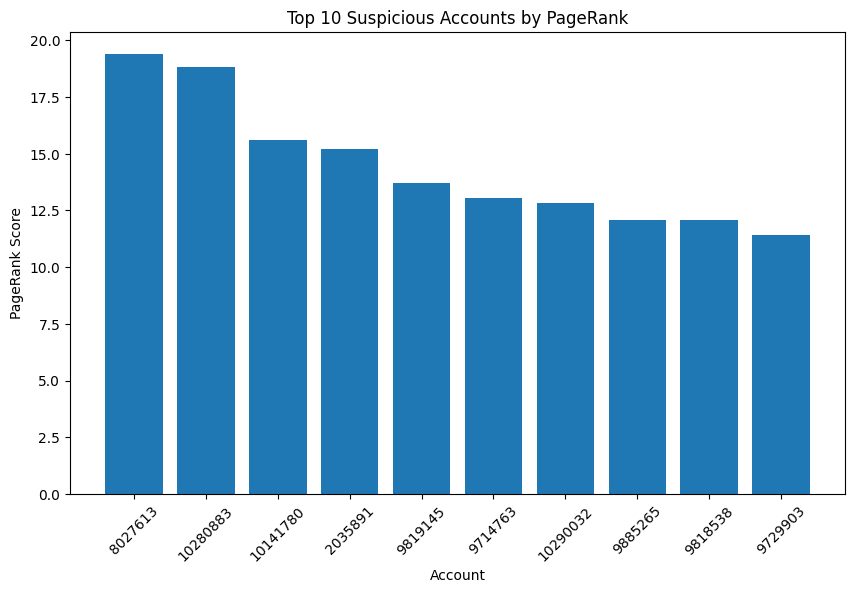

In [35]:
# Ensure top 10 records are sorted by PageRank score
top_10 = pagerank_pd.sort_values(by="pagerank", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10["id"].astype(str), top_10["pagerank"])
plt.xlabel("Account")
plt.ylabel("PageRank Score")
plt.title("Top 10 Suspicious Accounts by PageRank")
plt.xticks(rotation=45)
plt.show()

## Community Detection

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------+--------+
|      id|   label|
+--------+--------+
|10586842| 6553972|
|  952101| 1852144|
| 8311671|10551794|
|  595718| 7620442|
| 6200098| 5436981|
| 3074938| 1008566|
|10128874| 9514990|
| 9778785| 1866466|
| 9046944| 9073807|
|  658773| 5727337|
|  468818| 6515914|
| 7753735| 8349412|
|  928453|10628396|
| 9770321|  524479|
| 1732400| 1778696|
| 7138767| 8814925|
| 8563002| 5008460|
|10624835| 2332457|
| 3171719|10591108|
| 3942878| 2584163|
+--------+--------+
only showing top 20 rows



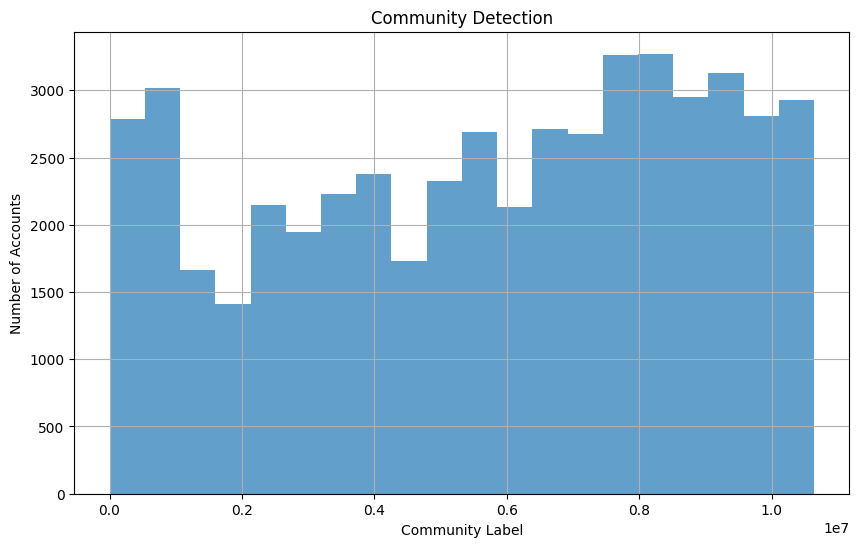

In [36]:
# Label propagation for community detection
communities = graph.labelPropagation(maxIter=5)
communities.show()

community_pd = communities.toPandas()
plt.figure(figsize=(10, 6))
plt.hist(community_pd["label"], bins=20, alpha=0.7)
plt.xlabel("Community Label")
plt.ylabel("Number of Accounts")
plt.title("Community Detection")
plt.grid()
plt.show()

### Added code

In [38]:
from pyspark.sql.functions import sum, avg, countDistinct, col, variance, max, min,count

In [40]:
community_sizes = community_pd.groupby("label").size().reset_index(name="size")
top_communities = community_sizes.sort_values(by="size", ascending=False).head(5)

# Create `top_anomalies` as a list of top community labels
top_anomalies = top_communities["label"].tolist()

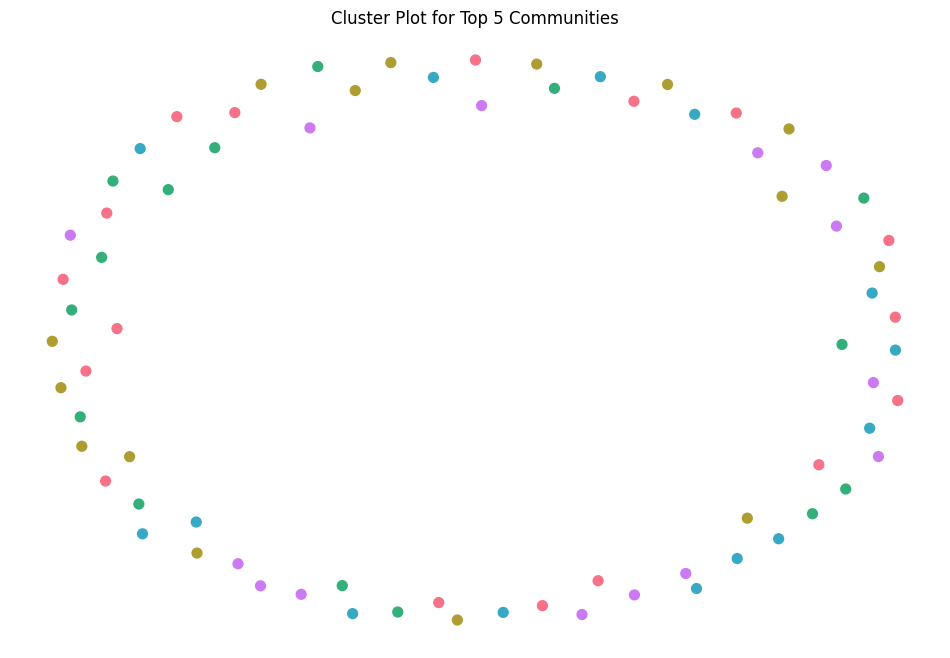

In [43]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

community_membership = communities.toPandas()
top_communities = top_anomalies
top_accounts = community_membership[community_membership['label'].isin(top_communities)]

# Graph object using NetworkX
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in top_accounts.iterrows():
    G.add_node(row['id'], label=row['label'])
edges_pd = edges.toPandas()

for _, row in edges_pd.iterrows():
    if row['src'] in top_accounts['id'].values and row['dst'] in top_accounts['id'].values:
        G.add_edge(row['src'], row['dst'])

try:
    import seaborn as sns
    community_colors = {label: color for label, color in zip(top_communities, sns.color_palette("husl", len(top_communities)))}
except ImportError:
    print("Seaborn not found. Please install it using: !pip install seaborn")
    community_colors = {label: plt.cm.get_cmap("viridis")(i / len(top_communities)) for i, label in enumerate(top_communities)}


# Set up the layout for the plot (positioning the nodes)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
for community in top_communities:
    nodes_in_community = [node for node, data in G.nodes(data=True) if data['label'] == community]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=50, node_color=[community_colors[community]] * len(nodes_in_community))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Cluster Plot for Top 5 Communities")
plt.axis("off")
plt.show()

In [44]:
community_sizes = community_pd['label'].value_counts()
print(community_sizes[:21])

label
9962372     17
9772449     15
8751462     15
7963684     14
9924029     14
9399569     13
10584344    13
10582640    13
10576733    13
9818886     13
5197535     12
9411277     12
7676501     12
10163144    12
7949952     11
6549110     11
9320593     11
9197015     10
590169      10
8141327     10
9278764     10
Name: count, dtype: int64
